In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches

from pipeline.python.classifications import decode_utils as dutils

In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


In [4]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Responsive params
responsive_test = 'nstds' # 'nstds' #'ROC' #None
nstd_thr=10
responsive_thr = nstd_thr if responsive_test=='nstds' else 0.05 #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None

response_type = 'dff'
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
print(response_str)

#### Experiment to decode
experiment = 'blobs'
stim_filterby = 'first'
has_gratings = False
if experiment=='blobs':
    stimstr = 'hasgratings' if has_gratings else 'blobsonly'
else:
    stimstr = 'gratingsonly'
filter_str = 'filter_%s_%s' % (stim_filterby, stimstr)
print(filter_str)

dff_nstds-thr-10.00
filter_first_blobsonly


# Set ouptut dir

In [5]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

decoding_dir = os.path.join(aggregate_dir, 'decoding')
print(decoding_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding


In [102]:
os.listdir(decoding_dir)

['linear-separability',
 'match_RF_overlap',
 'by_ncells',
 'train-1_test-1',
 'train-subset',
 'train-anchors']

# Classify A/B, by NCELLS

In [39]:
train_str = 'traintest_by-ncells' 
glob.glob(os.path.join(decoding_dir, 'by_ncells', '%s_iter*.pkl' % (train_str)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells/traintest_by-ncells_iter-500_overlap-0.80_results_20200926.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells/traintest_by-ncells_iter-50_overlap-0.80_results_20200926.pkl']

In [95]:
dst_dir = os.path.join(decoding_dir, 'by_ncells')
os.listdir(dst_dir)

['traintest_by-ncells_iter-500_overlap-0.80_results_20200926.pkl',
 'traintest_by-ncells_iter-500_overlap-0.80_params_20200926.json',
 'traintest_by-ncells_iter-500__heldout_test_scorezoom_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_test_score_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_log2MI_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_log2MIzoom_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_aMI_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_aMIzoom_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_overlap-0.80_decode_heldout_log2MI_20200926.svg',
 'traintest_by-ncells_overlap-0.80_decode_heldout_log2MIzoom_20200926.svg',
 'traintest_by-ncells_overlap-0.80_decode_heldout_test_scorezoom_20200926.svg',
 'traintest_by-ncells_overlap-0.80_d

In [96]:
n_iterations = 500
overlap_thr=0.8
train_str = 'traintest_by-ncells' 
glob.glob(os.path.join(dst_dir, '%s_iter-%i_overlap-%.2f_*.pkl' % (train_str, n_iterations, overlap_thr)))
#glob.glob(os.path.join(dst_dir, '*overlap-%.2f_*.pkl' % (overlap_thr)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells/traintest_by-ncells_iter-500_overlap-0.80_results_20200926.pkl']

In [97]:
results_dfile = glob.glob(os.path.join(dst_dir, 
                                      '%s_iter-%i_overlap-%.2f_*.pkl' % (train_str, n_iterations, overlap_thr)))[0]

# results_dfile = glob.glob(os.path.join(dst_dir, 
#                                        '*overlap-%.2f_*.pkl' % (overlap_thr)))[0]
#results_dfile = os.path.join(dst_dir, 'results_20200924.pkl')
# 'results_overlap-0.80.pkl' 200 cells, incoplete

with open(results_dfile, 'rb') as f:
    results = pkl.load(f)
if isinstance(results, dict):
    print(results.keys())
    results = results['pooled']
    #sdf = resultsdict['sdf']
else:
    results = results
    
results_basename = os.path.splitext(os.path.split(results_dfile)[-1])[0]
params_dfile = '%s.json' % os.path.splitext(results_dfile)[0].replace('results', 'params')
if os.path.exists(params_dfile):
    with open(params_dfile, 'r') as f:
        params = json.load(f)
    print("Train/test params for %s:" % train_str)
    pp.pprint(params)
else:
    print("No params")
print("File basename: %s" % results_basename)

['pooled']
Train/test params for traintest_by-ncells:
{   u'C_value': None,
    u'cv': True,
    u'cv_nfolds': 5,
    u'n_iterations': 500,
    u'overlap_thr': 0.8,
    u'test_split': 0.2}
File basename: traintest_by-ncells_iter-500_overlap-0.80_results_20200926


In [98]:
results.keys()

Index([u'C', u'C_sem', u'C_std', u'fit_time', u'fit_time_sem', u'fit_time_std',
       u'heldout_MI', u'heldout_MI_sem', u'heldout_MI_std', u'heldout_aMI',
       u'heldout_aMI_sem', u'heldout_aMI_std', u'heldout_log2MI',
       u'heldout_log2MI_sem', u'heldout_log2MI_std', u'heldout_test_score',
       u'heldout_test_score_sem', u'heldout_test_score_std', u'n_units',
       u'overlap', u'score_time', u'score_time_sem', u'score_time_std',
       u'test_accuracy', u'test_accuracy_sem', u'test_accuracy_std',
       u'test_precision_macro', u'test_precision_macro_sem',
       u'test_precision_macro_std', u'test_recall_macro',
       u'test_recall_macro_sem', u'test_recall_macro_std', u'train_accuracy',
       u'train_accuracy_sem', u'train_accuracy_std', u'train_precision_macro',
       u'train_precision_macro_sem', u'train_precision_macro_std',
       u'train_recall_macro', u'train_recall_macro_sem',
       u'train_recall_macro_std', u'visual_area'],
      dtype='object')

In [99]:
date_str = results_basename.split('_')[-1]
plot_str = '_test_%s_overlap-%.2f' % (train_str, overlap_thr)
fig_str = '%s_%s' % (response_str, filter_str)
data_id = '%s|%s' % (traceid, fig_str)
print(data_id)
print(plot_str)
print(date_str)

traces001|dff_nstds-thr-10.00_filter_first_blobsonly
_test_traintest_by-ncells_overlap-0.80
20200926


In [100]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.pyc'>

<IPython.core.display.Javascript object>


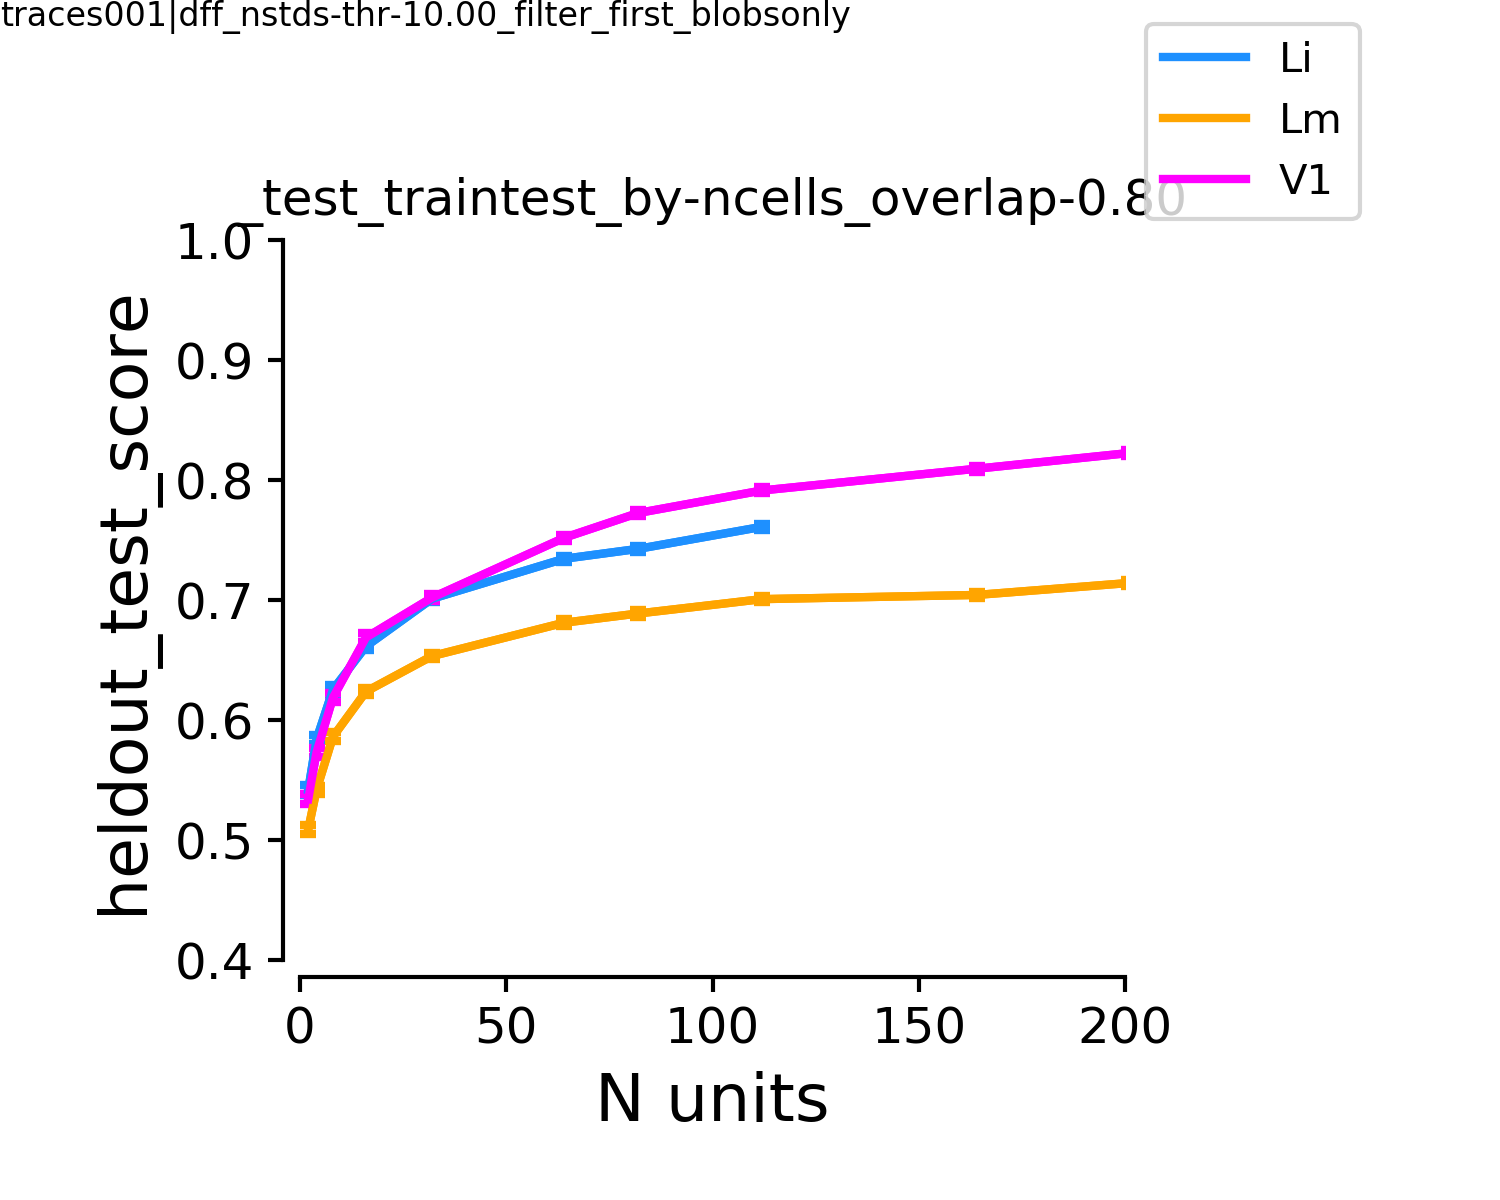

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells', '_test_traintest_by-ncells_overlap-0.80_decode_heldout_test_scorezoom')


<IPython.core.display.Javascript object>


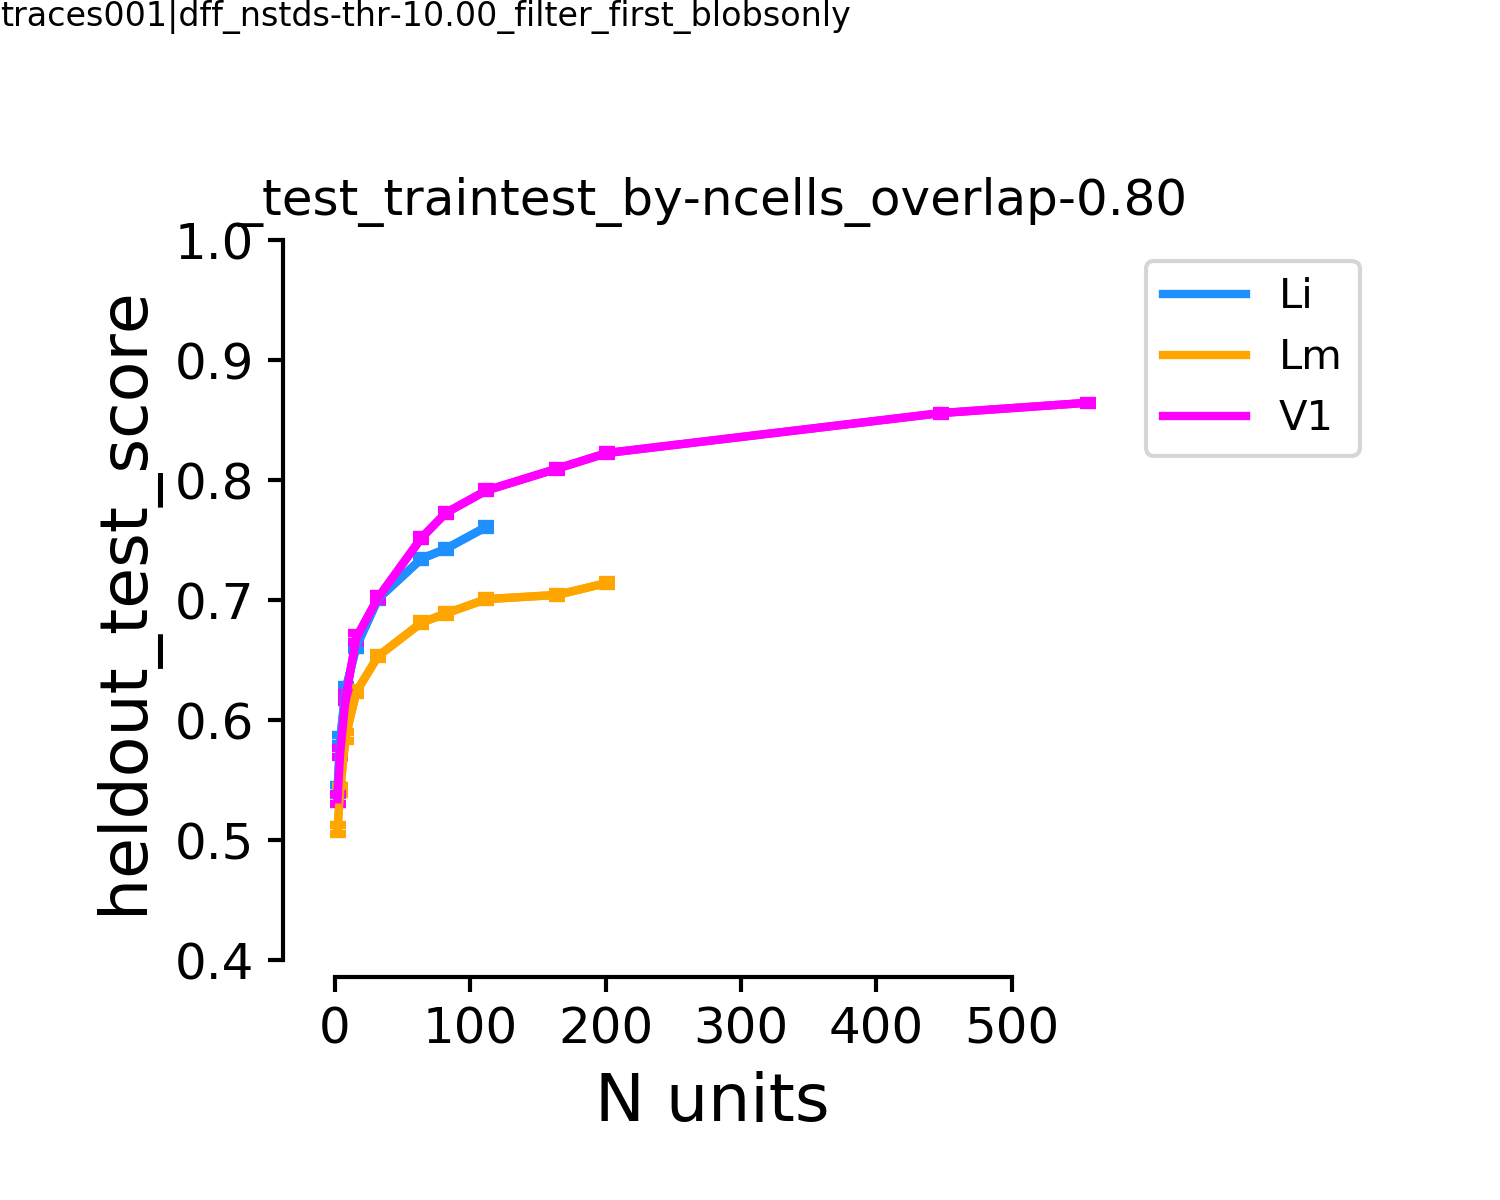

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells', '_test_traintest_by-ncells_overlap-0.80_decode_heldout_test_score')


In [101]:
metric = 'heldout_test_score'
dutils.default_classifier_by_ncells(results, metric=metric, plot_str=plot_str, date_str=date_str,
                                    dst_dir=dst_dir, data_id=data_id, area_colors=area_colors, xlim=200)
                                    

# Test Generalization -- size

In [60]:
n_train_configs=4
n_iterations = 100
sample_ncells=112
train_str = 'train-%i_sample-%i_iter-%i' % (n_train_configs, sample_ncells, n_iterations)  

overlap_thr=0.8
glob.glob(os.path.join(decoding_dir, 'match_RF_overlap', '%s*.pkl' % (train_str)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap/train-4_sample-112_iter-100_results.pkl']

In [65]:
overlap_dir = os.path.join(decoding_dir, 'match_RF_overlap')
results_dfile = glob.glob(os.path.join(overlap_dir, '%s*.pkl' % (train_str)))[0]
with open(results_dfile, 'rb') as f:
    results = pkl.load(f)

results_basename = os.path.splitext(os.path.split(results_dfile)[-1])[0]
print("File basename: %s" % results_basename)

File basename: train-4_sample-112_iter-100_results


In [12]:
animalid = 'JC097'
session = '20190616'
fovnum = 1
exp = util.Objects(animalid, session, 'FOV%i_zoom2p0x' % fovnum, traceid=traceid)
sdf = exp.get_stimuli()


In [67]:
plot_str = '%s_overlap-%.2f' % (train_str, overlap_thr)
fig_str = '%s_%s' % (response_str, filter_str)
data_id = '%s|%s' % (traceid, fig_str)
print(data_id)

traces001|dff_nstds-thr-10.00_filter_first_blobsonly


In [71]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

<IPython.core.display.Javascript object>


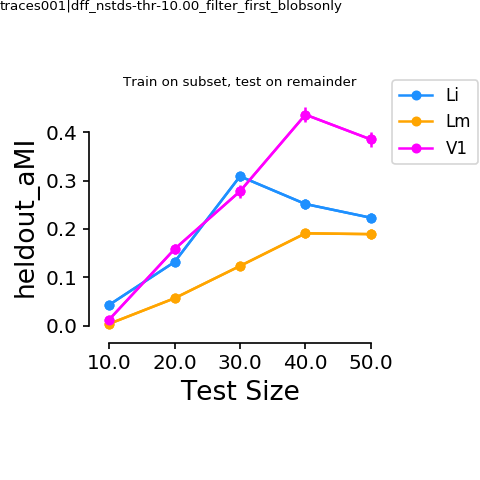

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_overlap-0.80_generalize_size')


<IPython.core.display.Javascript object>


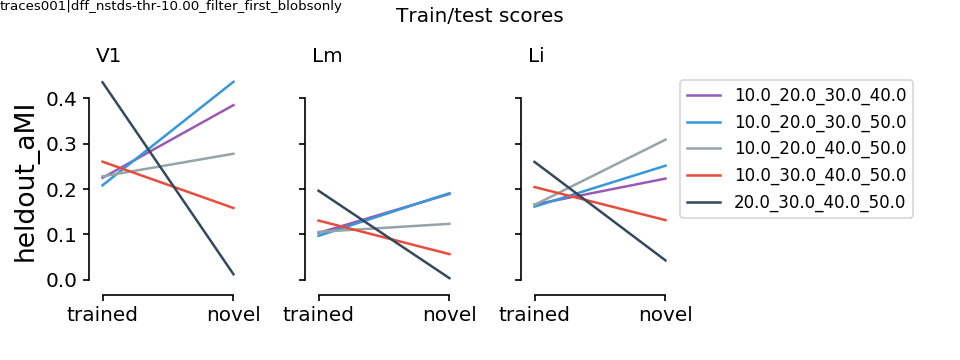

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_overlap-0.80_generalize_size__avg-novel-v-trained')


<IPython.core.display.Javascript object>


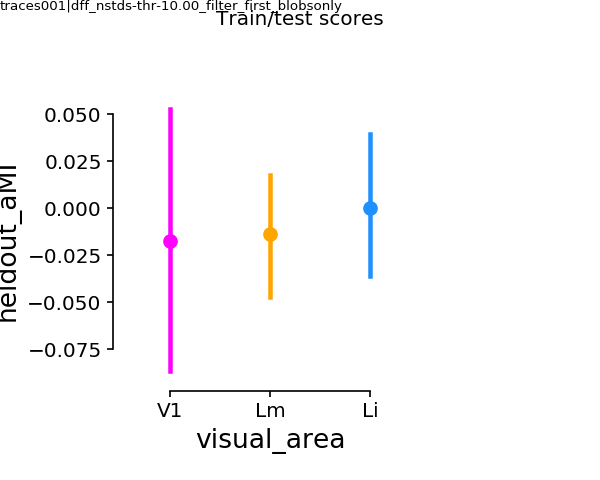

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_overlap-0.80_generalize_size__avg-novel-v-trained-difference')


In [73]:
metric = 'heldout_aMI'
dutils.default_train_test_subset(results, sdf, metric=metric, area_colors=area_colors, 
                                 plot_str=plot_str, data_id=data_id, dst_dir=overlap_dir)


In [77]:
results.head()

,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_transform,train_accuracy,train_precision_macro,train_recall_macro,train_transform,iteration,n_units,visual_area,overlap
0,0.010,0.002216,0.055217,0.065015,0.079662,0.659574,0.002186,0.773052,0.780050,0.773099,10.0_20.0_30.0_40.0,0.878349,0.878713,0.878306,10.0_20.0_30.0_40.0,0,112,Li,0.8
1,0.010,0.002216,0.167874,0.232338,0.242191,0.758621,0.002186,0.773052,0.780050,0.773099,50.0,0.878349,0.878713,0.878306,10.0_20.0_30.0_40.0,0,112,Li,0.8
2,0.001,0.002637,0.134455,0.180996,0.193977,0.744681,0.002641,0.696989,0.728557,0.698246,10.0_20.0_30.0_50.0,0.772837,0.806416,0.773706,10.0_20.0_30.0_50.0,0,112,Li,0.8
3,0.001,0.002637,0.062245,0.077773,0.089801,0.637931,0.002641,0.696989,0.728557,0.698246,40.0,0.772837,0.806416,0.773706,10.0_20.0_30.0_50.0,0,112,Li,0.8
4,0.010,0.002267,0.153134,0.208435,0.220926,0.765957,0.002227,0.675786,0.691301,0.675439,10.0_20.0_40.0_50.0,0.850086,0.851258,0.850153,10.0_20.0_40.0_50.0,0,112,Li,0.8


# Test generalization - 1 size

In [83]:
n_train_configs=1
n_iterations = 100
sample_ncells=112
train_str = 'train-%i_sample-%i_iter-%i' % (n_train_configs, sample_ncells, n_iterations)  

overlap_thr=0.8
glob.glob(os.path.join(decoding_dir, 'train-1_test-1', '%s*.pkl' % (train_str)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1/train-1_sample-112_iter-100_results.pkl']

In [84]:
dst_dir = os.path.join(decoding_dir, 'train-1_test-1')
results_dfile = glob.glob(os.path.join(dst_dir, '%s*.pkl' % (train_str)))[0]
with open(results_dfile, 'rb') as f:
    results = pkl.load(f)

results_basename = os.path.splitext(os.path.split(results_dfile)[-1])[0]
print("File basename: %s" % results_basename)

File basename: train-1_sample-112_iter-100_results


In [85]:
plot_str = '%s_overlap-%.2f' % (train_str, overlap_thr)
fig_str = '%s_%s' % (response_str, filter_str)
data_id = '%s|%s' % (traceid, fig_str)
print(data_id)

traces001|dff_nstds-thr-10.00_filter_first_blobsonly


<IPython.core.display.Javascript object>


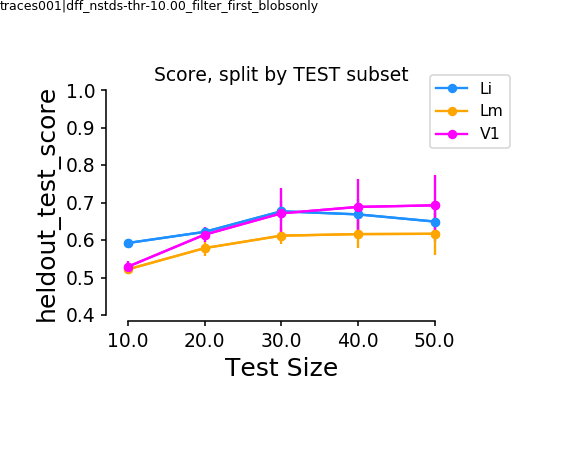

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_heldout_test_score_by-test-size')


In [468]:
metric = 'heldout_test_score'
testdf = pd.concat([g[g['test_transform']!=train].groupby(['visual_area', 'test_transform']).mean() \
           for (visual_area, train), g in results.groupby(['visual_area', 'train_transform'])]).reset_index()


fig, ax = pl.subplots(figsize=(5,4), dpi=150)
# dutils.plot_scores_by_test_set(results, sdf, metric=metric, area_colors=area_colors, ax=ax, plot_sem=True)

sizes = [str(s) for s in sdf['size'].unique()]
markersize=5
for visual_area, vdf in testdf.groupby(['visual_area']):
    #for train, traindf in vdf.groupby(['train_transform']):
    mean_vals = vdf.groupby(['test_transform']).mean()[metric]
    sem_vals = vdf.groupby(['test_transform']).sem()[metric]

    ax.plot(np.arange(0, len(sizes)), mean_vals, color=area_colors[visual_area],
               marker='o', markersize=markersize, label=visual_area)
    ax.errorbar(np.arange(0, len(sizes)), mean_vals, yerr=sem_vals, color=area_colors[visual_area],
               marker='o', markersize=markersize, label=None)

    ax.set_xticks(np.arange(0, len(sizes)))
    ax.set_xticklabels(sizes)

ax.set_xlabel('Test Size', fontsize=16)
ax.set_ylabel(metric, fontsize=16)
pl.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.3, wspace=0.3)

ax.legend(bbox_to_anchor=(1.2, 1.1))

if metric=='heldout_test_score':
    ax.set_ylim([0.4, 1])
else:
    ax.set_ylim([0, 0.4])
sns.despine(trim=True,offset=4)

putils.label_figure(fig, data_id)
ax.set_title("Score, split by TEST subset")

figname = '%s_%s_by-test-size' % (plot_str, metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [385]:
sizes = sdf['size'].unique()

#### Relative score

In [517]:
subtract_novel=True
metric = 'heldout_test_score'

metric_names = [p for p in results.columns if 'heldout' in p or 'C' in p]
mean_results=results.groupby(['visual_area', 'train_transform', 'test_transform']).mean()[metric_names].reset_index()

relative_df = pd.concat([pd.DataFrame({
                          'trained': [float(g[g['test_transform']==train][metric].values) for _ in np.arange(0, len(g)-1)],
                          'novel': g[g['test_transform']!=train][metric],
                          'visual_area': [visual_area for _ in np.arange(0, len(g)-1)], 
                          'train_transform': [train for _ in np.arange(0, len(g)-1)], 
                          'test_transform': g[g['test_transform']!=train]['test_transform']}) \
             for (visual_area,train), g in mean_results.groupby(['visual_area', 'train_transform'])])

if subtract_novel:
    relative_df['relative_%s' % metric] = (relative_df['trained'] - relative_df['novel']) #/ relative_df['trained']
else:
    relative_df['relative_%s' % metric] = (relative_df['novel'] - relative_df['trained']) #/ relative_df['trained']

relative_str='subtract-novel' if subtract_novel else 'subtract-trained'

<IPython.core.display.Javascript object>


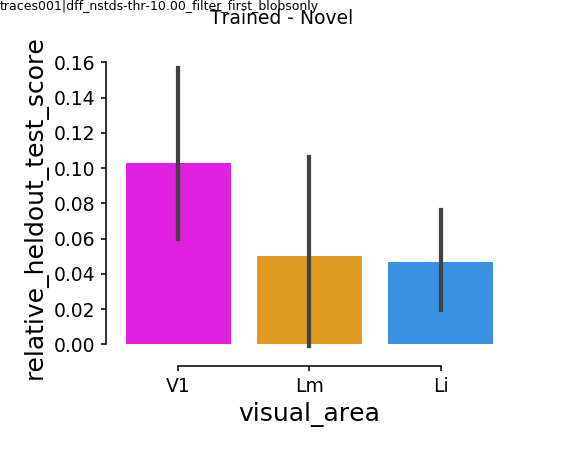

********* [relative_heldout_test_score] Mann-Whitney U test(mc=holm) **********
[('V1', 'Lm')] p=0.115 (holm), reject H0=False
[('V1', 'Li')] p=0.115 (holm), reject H0=False
[('Lm', 'Li')] p=0.299 (holm), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_avg-novel-v-trained_relative_heldout_test_score_subtract-novel')


In [518]:
fig, ax = pl.subplots(1, dpi=dpi, figsize=(5,4), sharex=True, sharey=True)
sns.barplot(x='visual_area', y='relative_%s' % metric, data=relative_df, ax=ax,
           order=visual_areas, palette=area_colors)
#sns.stripplot(x='visual_area', y='relative_%s' % metric, data=relative_df, ax=ax,
#            hue='test_transform', palette='colorblind', order=visual_areas, dodge=True)
statresults, ax = aggr.plot_mannwhitney(relative_df, metric='relative_%s' % metric, multi_comp_test='holm', ax=ax)
sns.despine(trim=True, offset=4)

pl.subplots_adjust(left=0.2, right=0.9, bottom=0.2)

putils.label_figure(fig, data_id)


if subtract_novel:
    fig.suptitle('Trained - Novel')
else:
    fig.suptitle('Novel - Trained')

figname = '%s_avg-novel-v-trained_relative_%s_%s' % (plot_str, metric, relative_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


<IPython.core.display.Javascript object>


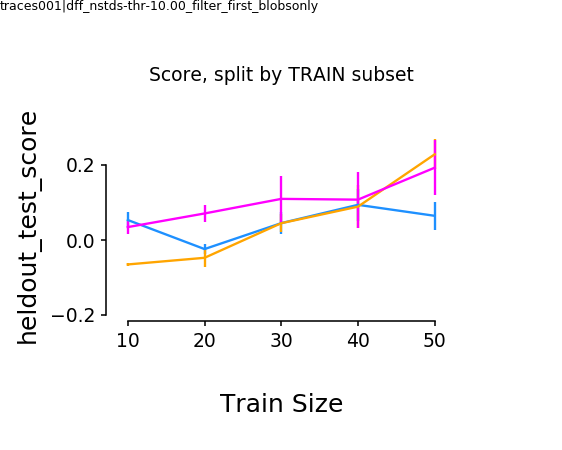

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_heldout_test_score_by-train-size')


In [465]:
# Plot.

sizes = sdf['size'].unique()

fig, ax = pl.subplots(1, dpi=dpi, figsize=(5,4), sharex=True, sharey=True)

for visual_area, vdf in relative_df.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    
    mean_vals = vdf.groupby(['train_transform']).mean()['relative_%s' % metric]
    sem_vals = vdf.groupby(['train_transform']).sem()['relative_%s' % metric]
    xv = sizes
    
    ax.errorbar(xv, mean_vals, yerr=sem_vals, color=area_colors[visual_area])

    #ax.axhline(y=0.5, color='k', linestyle=':')
    #ax.set_ylim([0.4, 1])
    ax.set_xticks(sizes)
    ax.set_xticklabels([int(s) for s in sizes])
    
ax.set_ylim([-0.2, 0.4])
fig.text(0.5, 0.1, 'Train Size', ha="center", va="center", fontsize=16)
fig.text(0.05,0.5, metric, ha="center", va="center", rotation=90, fontsize=16)
pl.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.3, wspace=0.3)
sns.despine(trim=True, offset=4)


putils.label_figure(fig, data_id)

ax.set_title("Score, split by TRAIN subset")
figname = '%s_%s_by-train-size' % (plot_str, metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [479]:
reldf.head()

,heldout_log2MI,iteration,visual_area,train_transform,test_transform
0,0.0,0,Li,10.0,10.0
1,0.0,1,Li,10.0,10.0
2,0.0,2,Li,10.0,10.0
3,0.0,3,Li,10.0,10.0
4,0.0,4,Li,10.0,10.0


<IPython.core.display.Javascript object>


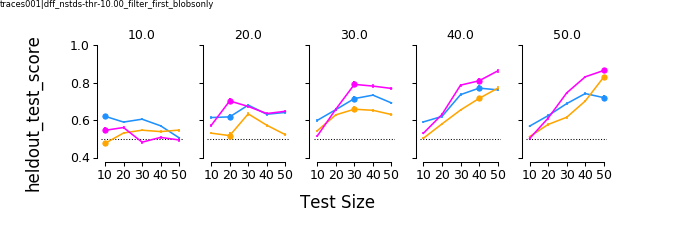

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_heldout_test_score_split-train-test-transform')


In [480]:
# Plot.

metric = 'heldout_test_score'

fig, axn = pl.subplots(1, 5, figsize=(9,3), sharey=True, sharex=False)
sizes = sdf['size'].unique()

marker='o'
markersize=5
for ax, (train_transform, traindf) in zip(axn.flat, results.groupby(['train_transform'])):
    
    for visual_area, vdf in traindf.groupby(['visual_area']):

        mean_vals = vdf.groupby(['test_transform']).mean()[metric]
        sem_vals = vdf.groupby(['test_transform']).sem()[metric]
        xv = vdf.groupby(['test_transform']).mean().index.values

        ax.errorbar(xv, mean_vals, yerr=sem_vals, color=area_colors[visual_area])
        train_ix = list(sizes).index(train_transform)
        
        ax.errorbar(xv[train_ix], mean_vals.loc[train_transform], yerr=sem_vals.loc[train_transform],
                 marker=marker,markersize=markersize, color=area_colors[visual_area])
        
        ax.set_xticks(xv)
        ax.set_xticklabels([int(s) for s in xv])
    
        ax.set_title(train_transform)
        
    if metric =='heldout_test_score':
        ax.set_ylim([0.4, 1])
        ax.axhline(y=0.5, linestyle=':', color='k', lw=1)
    
fig.text(0.5, 0.1, 'Test Size', ha="center", va="center", fontsize=16)
fig.text(0.05,0.5, metric, ha="center", va="center", rotation=90, fontsize=16)
pl.subplots_adjust(left=0.15, right=0.9, top=0.8, bottom=0.3, wspace=0.3)
sns.despine(trim=True, offset=4)

putils.label_figure(fig, data_id)

figname = '%s_%s_split-train-test-transform' % (plot_str, metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [481]:
print(metric)

heldout_test_score


In [87]:
test_minus_train=True
sizes = sdf['size'].unique()

metric = 'heldout_test_score'
r_list = []
for visual_area, vdf in results.groupby(['visual_area']):
    for train_transform, traindf in vdf.groupby(['train_transform']):
        t_sizes = [t for t in sizes if t!=train_transform]
        
        curr_train_vals = traindf[traindf['test_transform']==train_transform][metric].values
        curr_iters = traindf[traindf['test_transform']==train_transform]['iteration'].values
        for test_transform in sizes:
            curr_test_vals = traindf[traindf['test_transform']==test_transform][metric].values
            #rel_scores = (curr_train_vals - curr_test_vals) #* curr_train_vals
            if test_minus_train:
                rel_scores = (curr_test_vals - curr_train_vals) #* curr_train_vals
            else:
                rel_scores = (curr_train_vals - curr_test_vals) #* curr_train_vals
            reldf = pd.DataFrame({metric: rel_scores,
                                  'iteration': curr_iters})
            
            add_info = {'visual_area': visual_area, 'train_transform': train_transform, 
                        'test_transform': test_transform}
            reldf = putils.add_meta_to_df(reldf, add_info)
            r_list.append(reldf)
reldf = pd.concat(r_list, axis=0).reset_index(drop=True) 

<IPython.core.display.Javascript object>


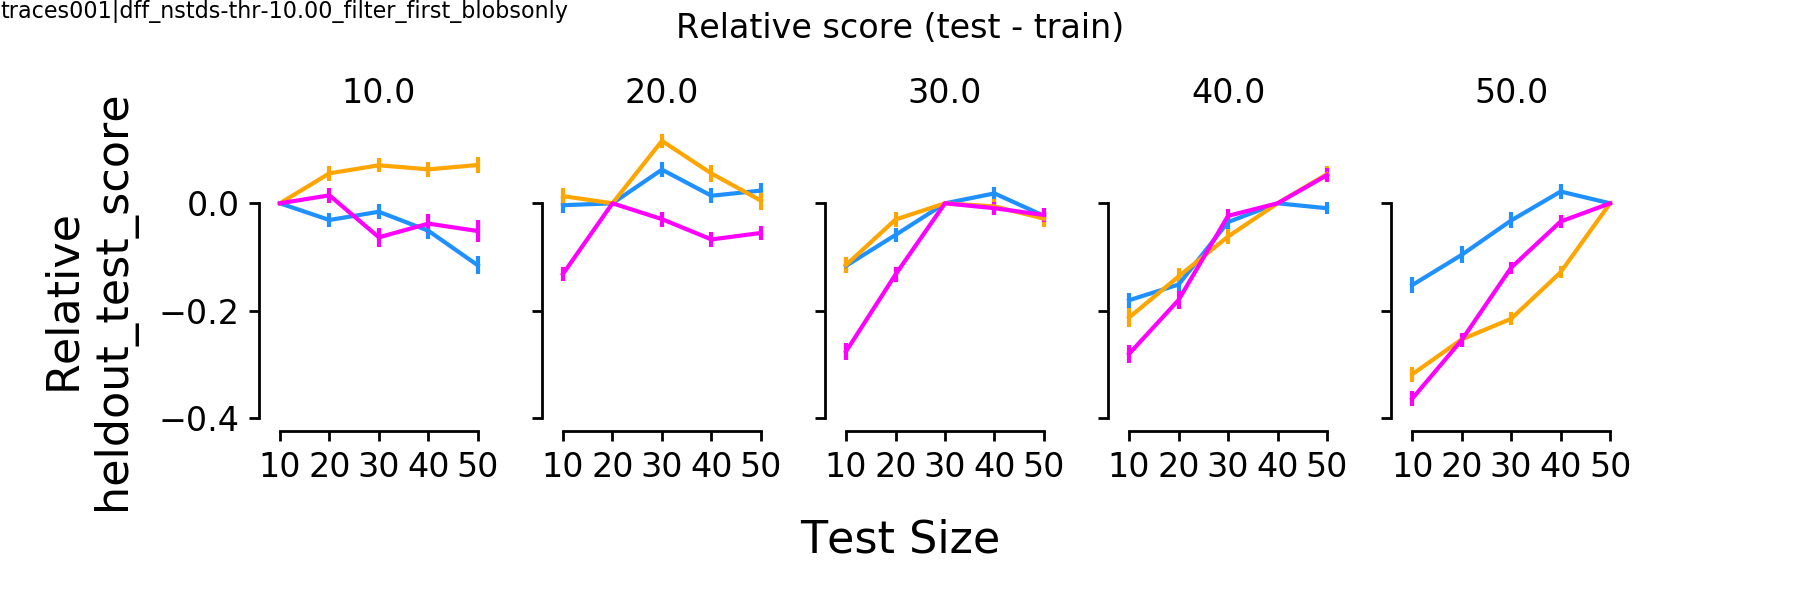

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_heldout_test_score_split-train-test-transform_RELATIVE-subtract-train')


In [89]:
fig, axn = pl.subplots(1, 5, figsize=(9,3), sharey=True, sharex=False)

for ax, (train_transform, traindf) in zip(axn.flat, reldf.groupby(['train_transform'])):
    
    for visual_area, vdf in traindf.groupby(['visual_area']):

#         mean_vals = vdf[vdf['test_transform']!=train_transform].groupby(['test_transform']).mean()[metric]
#         sem_vals = vdf[vdf['test_transform']!=train_transform].groupby(['test_transform']).sem()[metric]
#         xv = vdf[vdf['test_transform']!=train_transform].groupby(['test_transform']).mean().index.values
        mean_vals = vdf.groupby(['test_transform']).mean()[metric]
        sem_vals = vdf.groupby(['test_transform']).sem()[metric]
        xv = vdf.groupby(['test_transform']).mean().index.values

        ax.errorbar(xv, mean_vals, yerr=sem_vals, color=area_colors[visual_area])

        #ax.axhline(y=0.5, color='k', linestyle=':')
        #ax.set_ylim([0.4, 1])
        ax.set_xticks(xv)
        ax.set_xticklabels([int(s) for s in xv])
    
        ax.set_title(train_transform)
fig.text(0.5, 0.1, 'Test Size', ha="center", va="center", fontsize=16)
fig.text(0.05,0.5, 'Relative\n%s' % metric, ha="center", va="center", rotation=90, fontsize=16)
pl.subplots_adjust(left=0.15, right=0.9, top=0.8, bottom=0.3, wspace=0.3)
sns.despine(trim=True, offset=4)
putils.label_figure(fig, data_id)

if test_minus_train:
    fig.suptitle('Relative score (test - train)')
else:
    fig.suptitle('Relative score (train - test)')

relative_calc = 'subtract-train' if test_minus_train else 'subtract-test'

figname = '%s_%s_split-train-test-transform_RELATIVE-%s' % (plot_str, metric, relative_calc)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [371]:
train_str

'train-1_sample-112_iter-100'

In [372]:
plot_str

'train-1_sample-112_iter-100_overlap-0.80'

In [373]:
fig_str

'dff_nstds-thr-10.00_filter_first_blobsonly'

# Morphs

In [8]:
n_iterations = 100
sample_ncells=112
train_str = 'train-anchors-split-size_sample-%i_iter-%i' % (sample_ncells, n_iterations)  

overlap_thr=0.8
glob.glob(os.path.join(decoding_dir, 'train-anchors', '%s*.pkl' % (train_str)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors/train-anchors-split-size_sample-112_iter-100_results_1.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors/train-anchors-split-size_sample-112_iter-100_results2.pkl']

In [9]:
dst_dir = os.path.join(decoding_dir, 'train-anchors')
results_dfile = glob.glob(os.path.join(dst_dir, '%s*.pkl' % (train_str)))[1]
with open(results_dfile, 'rb') as f:
    results = pkl.load(f)

results_basename = os.path.splitext(os.path.split(results_dfile)[-1])[0]
print("File basename: %s" % results_basename)

File basename: train-anchors-split-size_sample-112_iter-100_results2


In [10]:
plot_str = '%s_overlap-%.2f' % (train_str, overlap_thr)
fig_str = '%s_%s' % (response_str, filter_str)
data_id = '%s|%s' % (traceid, fig_str)
print(data_id)

traces001|dff_nstds-thr-10.00_filter_first_blobsonly


<IPython.core.display.Javascript object>


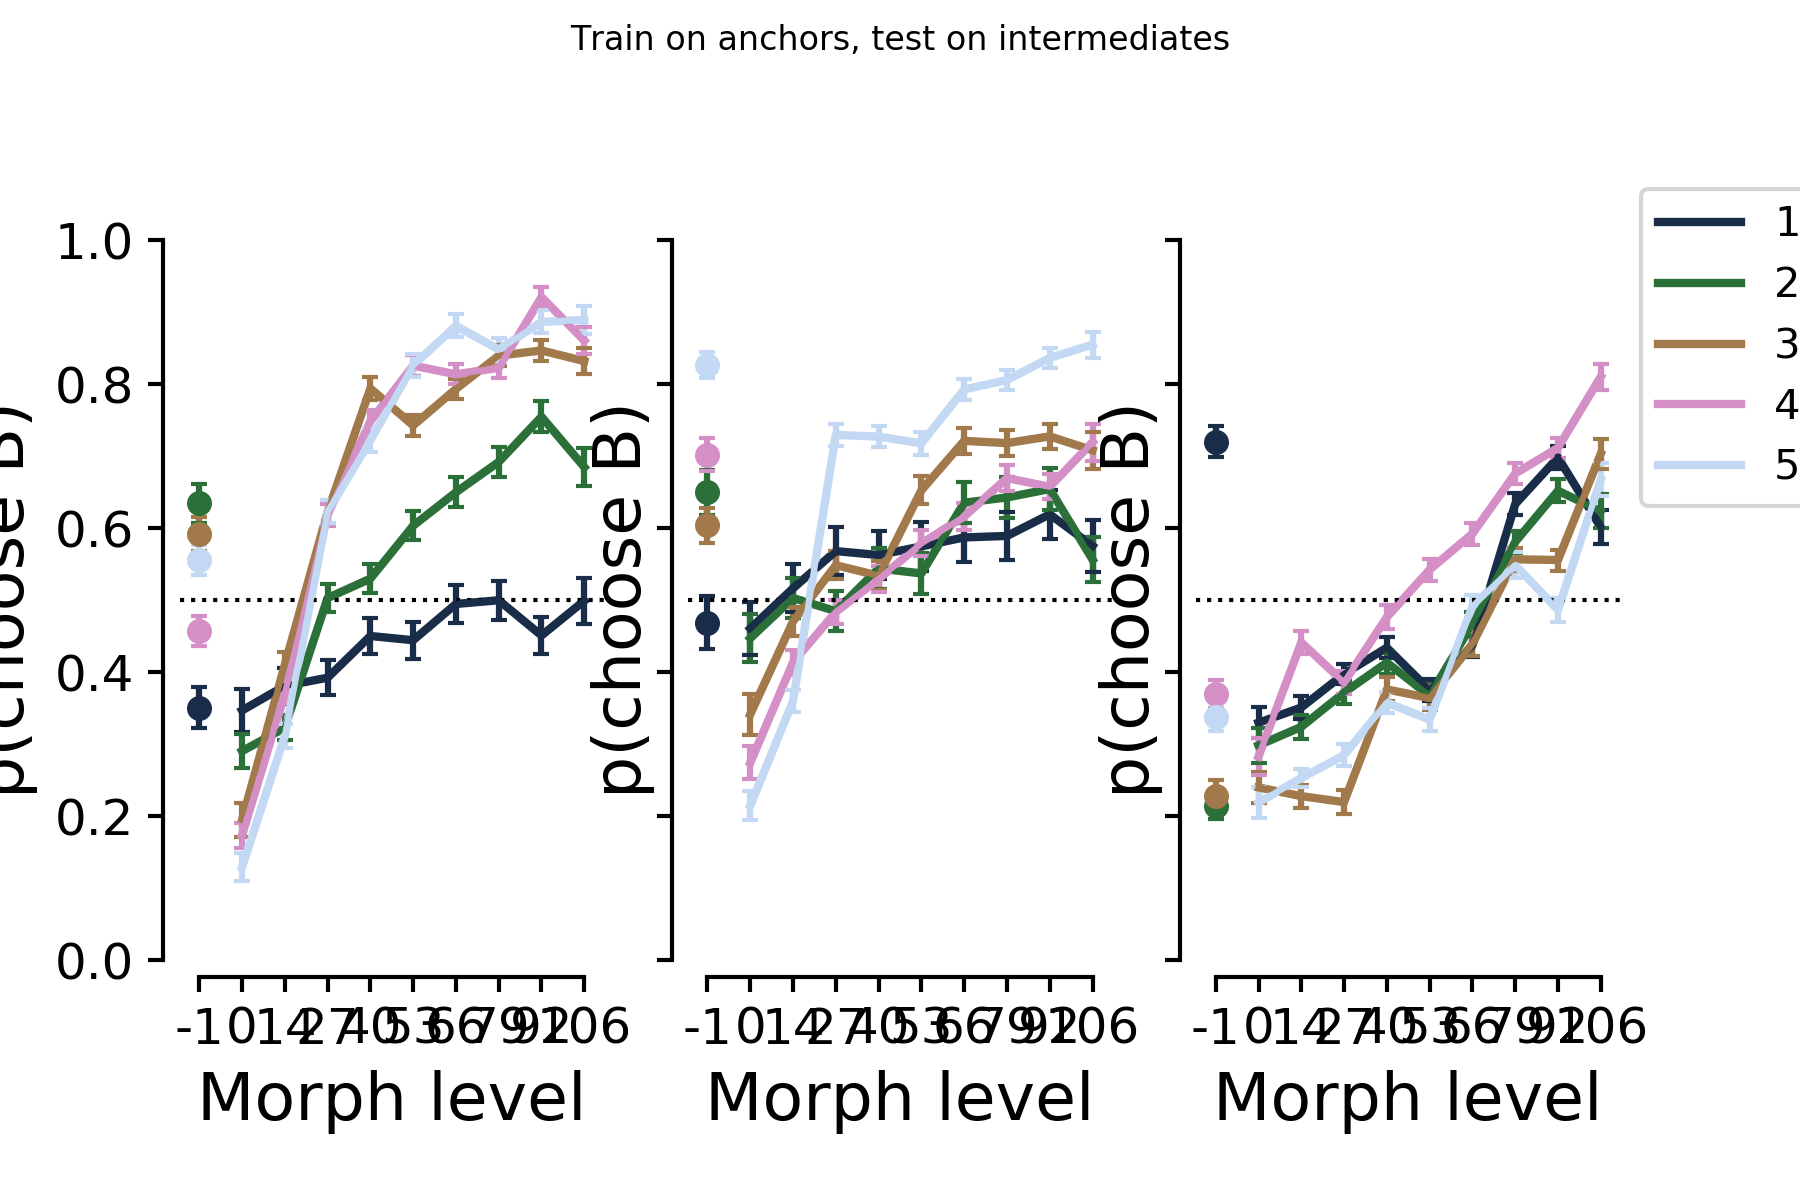

Text(0.5,0.98,u'Train on anchors, test on intermediates')

In [32]:
hue_size = True
col_name = 'morphlevel'
markersize=5
capsize=2
lw=2
alpha = 1

fig, axn = pl.subplots(1, 3, figsize=(6,4), sharex=True, sharey=True, dpi=150)
alphas = np.linspace(0.1, 1, 5)
ci = 95
shade=False
plot_ci=False
plot_luminance= True

plot_str = 'wLum' if plot_luminance else ''
plot_str = '%s_ci%i' % (plot_str, ci) if plot_ci else plot_str

for visual_area, vdf in results.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    ax = axn[ai]
    size_colors = sns.color_palette('cubehelix', n_colors=5)
    
    for si, (sz, df_) in enumerate(vdf.groupby(['size'])):
        morphlevels = sorted([s for s in sdf['morphlevel'].unique() if s!=-1])
        xvs = np.arange(1, len(morphlevels)+1) #if plot_luminance else np.arange(0, len(morphlevels))
        
        curr_color = size_colors[si] if hue_size else area_colors[visual_area]
        
        if plot_luminance:
            # plot luminance control
            control_val=-1
            if plot_ci:
                ctl, ctl_lo, ctl_hi = calculate_ci(df_[df_[col_name]==control_val]['p_chooseB'].values, ci=ci)
                yerr = [abs(np.array([ctl-ctl_lo])), abs(np.array([ctl_hi-ctl]))]
            else:
                ctl = df_[df_[col_name]==control_val]['p_chooseB'].mean()
                yerr = df_[df_[col_name]==control_val]['p_chooseB'].sem()

            ax.errorbar(0, ctl, yerr=yerr, color=curr_color,
                           marker='o', markersize=markersize, capsize=capsize, alpha=alpha)
            
        # plot morph curves
        if plot_ci:
            ci_vals = dict((val, calculate_ci(g['p_chooseB'].values, ci=ci)) \
                             for val, g in df_[df_[col_name].isin(morphlevels)].groupby([col_name]))
            mean_vals = np.array([ci_vals[k][0] for k in morphlevels])
            lowers = np.array([ci_vals[k][1] for k in morphlevels])
            uppers =  np.array([ci_vals[k][2] for k in morphlevels])
            yerr = [np.array([mean_vals - lowers]), np.array([mean_vals-uppers])]
        else:
            mean_vals = df_[df_[col_name].isin(morphlevels)].groupby([col_name]).mean()['p_chooseB']
            yerr = df_[df_[col_name].isin(morphlevels)].groupby([col_name]).sem()['p_chooseB']

        ax.plot(xvs, mean_vals, color=curr_color, lw=lw, alpha=alpha, label=sz)
        ax.errorbar(xvs, mean_vals, yerr=yerr, color=curr_color,
                          capsize=capsize, alpha=alpha, label=None)
        ax.set_ylim([0, 1])

    xticks = np.arange(0, len(morphlevels)+1) if plot_luminance else xvs
    xlabels = sdf['morphlevel'].unique() if plot_luminance \
                    else sdf[sdf['morphlevel']!=-1]['morphlevel'].unique()
    ax.set_xticks(xticks)
    ax.set_xticklabels( [int(m) for m in sorted(xlabels)] )
    ax.set_ylabel('p(choose B)')
    ax.set_xlabel('Morph level')
    
    
    ax.axhline(y=0.5, linestyle=':', color='k', lw=1)

    if ai==2:
        ax.legend(bbox_to_anchor=(1, 1.1))                               

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
sns.despine(trim=True, offset=4)
pl.suptitle("Train on anchors, test on intermediates", fontsize=8)


In [35]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

<IPython.core.display.Javascript object>


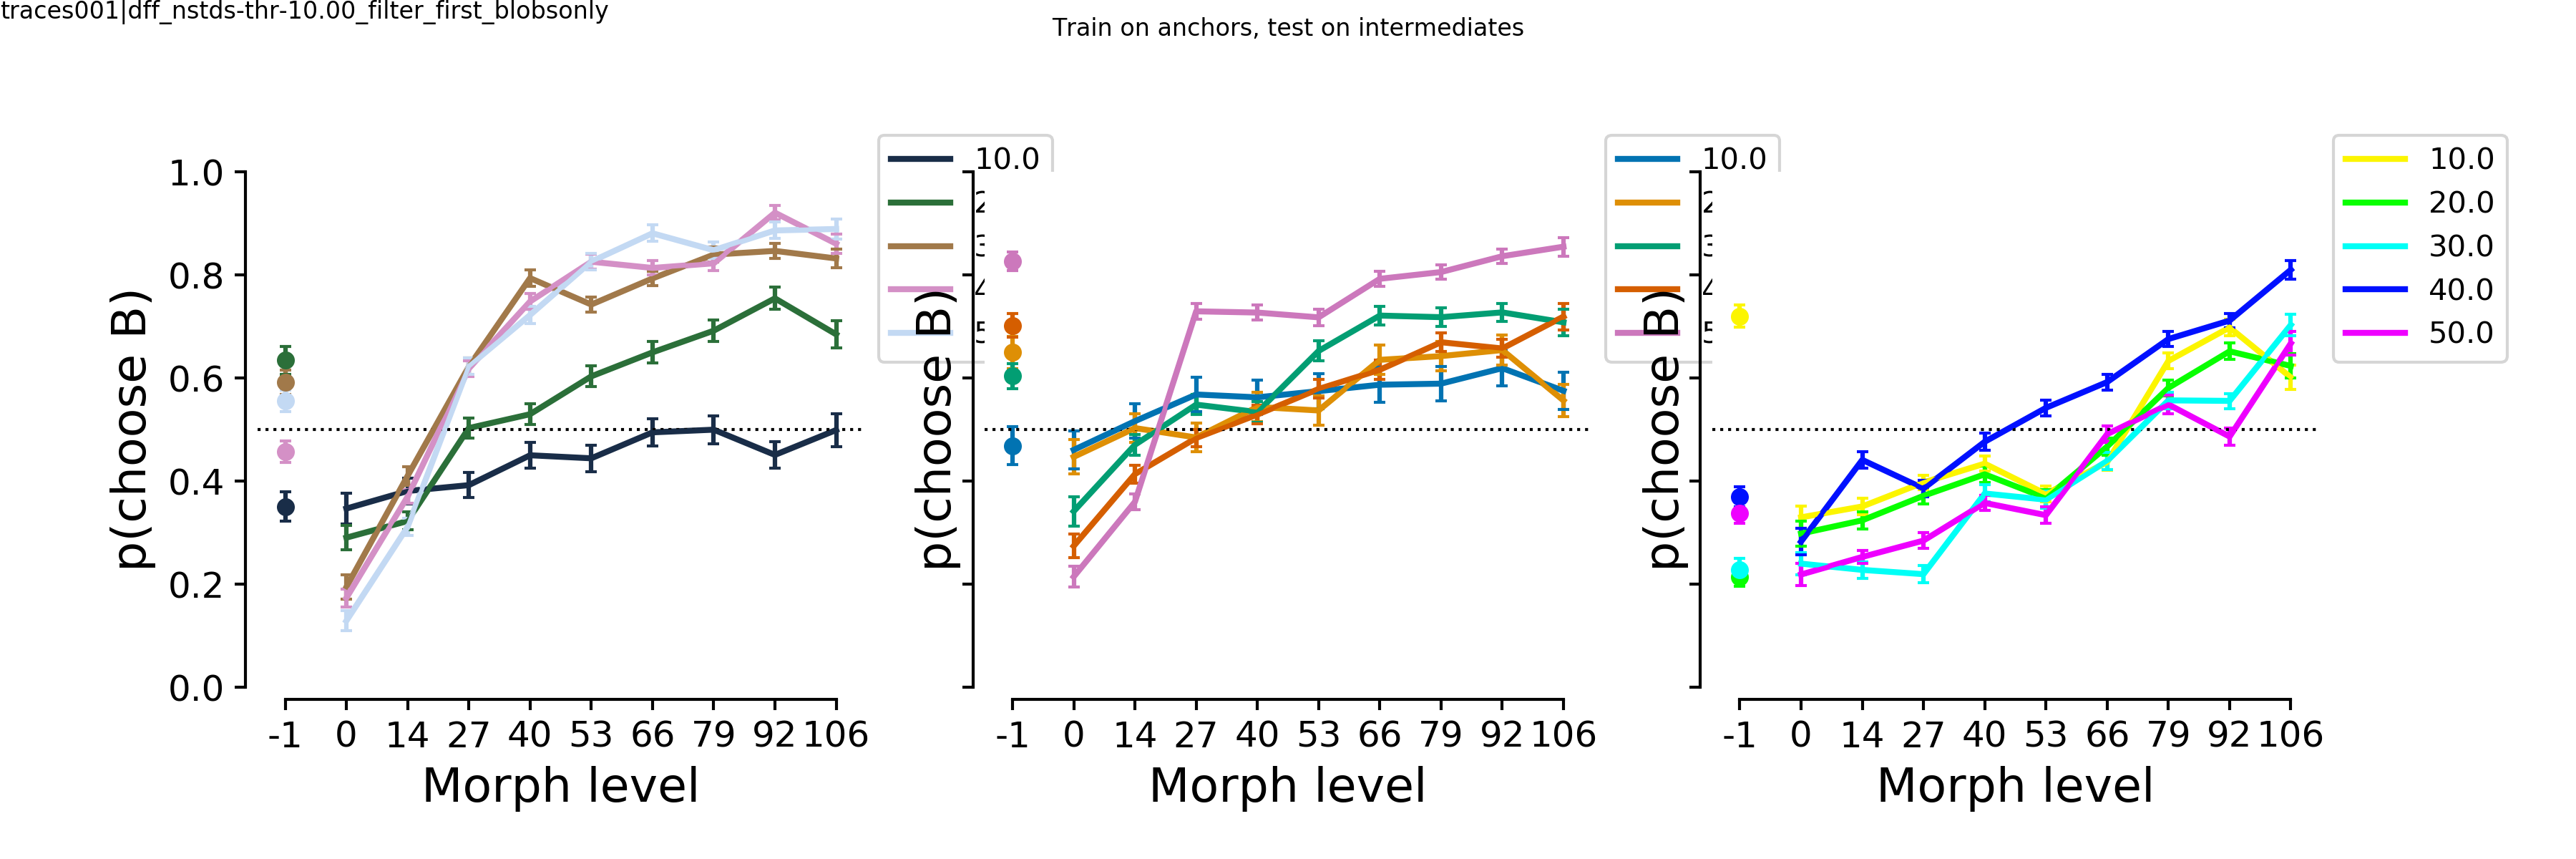

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors', 'train-anchors-split-size_sample-112_iter-100_morphcurves_split-size__wLum')


In [36]:
dutils.default_morphcurves_split_size(results, sdf, area_colors=area_colors, dst_dir=dst_dir, data_id=data_id,
                                    lw=lw, train_str=train_str, capsize=2, hue_size=True)